<a href="https://colab.research.google.com/github/Spencerguo11/CSE-450-/blob/main/Classification_Stroke_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. So, stroke is one of the diseases we should pay attention to. 

If we are able to make predictions for patients, it will be helpful to do something to prevent the patients from having stroke. But, how do we know if a patient is likely to have stroke? Thanks to the technology we have, we might be able to create a machine learning model to identify patients with stroke.

Here is a data about stroke disease from Kaggle.com. With that, we're going to create a model to help us identify patients with stroke.

Link: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

In [13]:
# Import all necessary libraries.

import pandas as pd
import numpy as np
import altair as alt 

In [14]:
# Read in data
dat = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')


**Data Exploratory Analysis**

In [15]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Here we see that there are some missing data for column bmi. Besides that, some of the columns have different data types, which is good for us to build a machine learning model. We'll do something to those columns to make the data consistent and clean.

In [16]:
# Drop the rows without a bmi
dat2 = dat.dropna().drop(['id'], axis = 1)

# Use get_dummy function to convert the cateogrical variables into dummy variables
dat3 = pd.get_dummies(dat2).astype('float64')

dat3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 5109
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             4909 non-null   float64
 1   hypertension                    4909 non-null   float64
 2   heart_disease                   4909 non-null   float64
 3   avg_glucose_level               4909 non-null   float64
 4   bmi                             4909 non-null   float64
 5   stroke                          4909 non-null   float64
 6   gender_Female                   4909 non-null   float64
 7   gender_Male                     4909 non-null   float64
 8   gender_Other                    4909 non-null   float64
 9   ever_married_No                 4909 non-null   float64
 10  ever_married_Yes                4909 non-null   float64
 11  work_type_Govt_job              4909 non-null   float64
 12  work_type_Never_worked          49

Here we can see our data is clean and organized, and it is ready to go.

In [17]:
# Let's take a look at the data after the wrangling.
dat3.head(10)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0.0,1.0,228.69,36.6,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,80.0,0.0,1.0,105.92,32.5,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,49.0,0.0,0.0,171.23,34.4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,79.0,1.0,0.0,174.12,24.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,81.0,0.0,0.0,186.21,29.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6,74.0,1.0,1.0,70.09,27.4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7,69.0,0.0,0.0,94.39,22.8,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9,78.0,0.0,0.0,58.57,24.2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
10,81.0,1.0,0.0,80.43,29.7,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
11,61.0,0.0,1.0,120.46,36.8,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [18]:
# Checking if the data is balanced or not

# creating a new conditional column
dat4 = dat3
dat4['Stroke_Status'] = np.where(dat4['stroke'] == 0, 'No', 'Yes')

dat3 = dat3.drop(['Stroke_Status'],axis=1)

alt.Chart(dat4).mark_bar().encode(
    alt.Y("Stroke_Status", title= 'Have a Stroke?'),
    alt.X("count(Stroke_Status)", title= 'Count'),
    color = 'Stroke_Status:N'
).properties(
    title = "Stroke Distribution"
)

alt.Chart(...)

From the graph above, we can see that the stroke dataset is not balanced. It is good to know now.

In order to undermine the influence comes from imbalanced data, we'll oversample the data before spliting the data into training set and testing set.

**Model Choice - Gradient Boosting Tree**

For this peoject, we are trying to build a machine learning model to predict the patients with stroke. The result we will see is either yes or no. There are many machine learning algorithms we can use for this problem. But using Gradient Boosting Tree model will be a good fit for two reasons. 

 Firstly, it is good fit for classification problem. The outcome we want is whether patients have stroke or not, so it is a typical classification problem. And Gradient Boosting algorithm will be a good choice for this project.

 Secondly, It is straight forward in term of how good our predictive model is. We use loss function to measure how good our model is at classifying the patients with stroke. And then, we can know what else we can do to improve our model.

 So, we'll use the Gradient Boosting algorithm to build a predictive model.

**Oversampleing & Data Spliting**

We separated the feathers and the target from this data. The taeget will be column stroke. 

From the data exploration analysis, we know that the data we have is imbalanced. In order to avoid the noise of this dataset, we'll oversample the dataset to ensure the data is balanced.

We randomized the data, which means the order of the data will be random campared to the original data. By doing so, we can ensure that the model will remain general and be less overfit. 

After that, we splited the data into training set and test set. 70% of the data are under the training set, and the other 30% of the data are under the test set. 

In [19]:
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score

# Separate feathers and the target
X = dat3.drop(['stroke'], axis = 1)
y = dat3[['stroke']]

# oversampling the data (It undermines the influence from the imbalanced data)
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_res, y_res= ros.fit_resample(X, y)

# Splite into train and test data for Gradient Boosting Tree model
X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=0.3, random_state=50, shuffle = True)


**Model Structure** 

Here is what we used to build a Gradient Boosting Classifier:
 
The number of boosting stages to perform: 200

Learning rate: 0.2

The maximum depth of the individual regression estimators: 7



In [20]:
# Build a model
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=.2,
     max_depth=7, random_state=0)

clf = clf.fit(X_train, y_train)

# Show the confusion matrix
y_prediction = clf.predict(X_test)

confusion_matrix(y_test, y_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[1373,   38],
       [   0, 1409]])

Here is the confusion matrix. 

True Positive: 1409. We predicted that 1409 patients would have stroke, and 1409 patients actually had stroke.

False Negative: 0. We predicted that no patients would have stroke, and no patient actually had stroke.

False Positive: 38. We predicted that 38 patients would have stroke, but they actually didn't have stroke.

True Negative: 1373. We predicted that 1373 patients wouldn't have stroke, and 1373 patients actually didn't have stroke.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


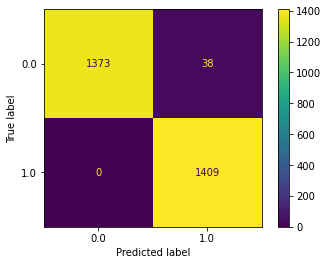

In [21]:
# Show the confusion matrix plot

plot_confusion_matrix(clf, X_test, y_test)

**Measure Choice**

From the data exploration analysis, we saw that the data we have is imblanced. We had much more patients with no stroke than those with stroke. In this case, using accuracy as measure will not be accurate. Instead of using accuracy, we'll use F1 score. 

To understand F1 score, we must understand what precision and recall are.


---


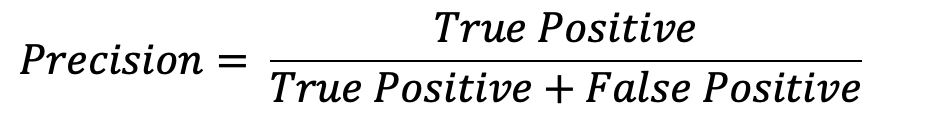



---

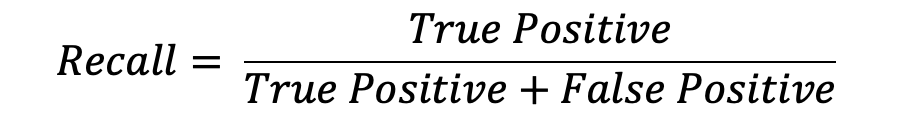




---

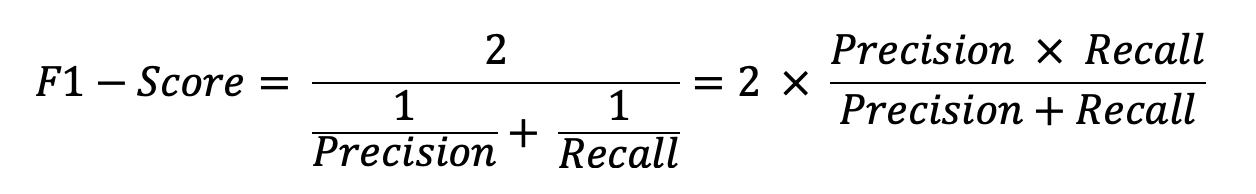


From the formulas above, we can see that what precision and recall are. And the F1-Score is the combination of both. A good F1-Score will have low false positves and low false negatives. So, F1-Score can be more accurate when we want to see if our perdictive model is good enough to predict patients with stroke.

If the F1-Score is 1, that is perfect. If the F1-Score is 0, then the model is useless.



In [22]:
# F1 score
f1_score(y_test, y_prediction)

0.9866946778711485

We ran our model and got a F1-Score of 0.9867, which is close to 1. So, our model can predict the patients with stroke very well.


**Areas to Explore More in the Future**


In [23]:
# Show the top 5 most important attributes
df_features = pd.DataFrame(
    {'f_names': X_train.columns, 
    'f_values': clf.feature_importances_}).sort_values('f_values', ascending = False)

Chart_feathers = alt.Chart(df_features).encode(
    alt.X('f_values', title = 'F Values'),
    alt.Y('f_names', title = 'Feather Names', sort=alt.EncodingSortField(field="f_value",order='descending'))
).mark_bar().transform_window(
    rank='rank(f_values)'
).transform_filter(
    (alt.datum.rank < 6)
).properties(
    title =  'Top 5 Most Important Factors Contributed to Stroke'
)

text = Chart_feathers.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text= alt.Text('f_values', format = '.4f')
)




In [24]:
Chart_feathers + text

alt.LayerChart(...)

From the graph above, we can see that the top five most important factors contributed to stroke. They are, in descending order, age of the patient, average glucose level in blood, body mass index, whether the patient never smoked, and whether the patient has hypertension.

How are these area effects the stroke? It could be one of the questions we can study later on.


**Conclusion**

In this project, we successfully used a stroke dataset from Kaggle.com to build a predictive model using Gradient Boosting algorithm. 

We oversampled the dataset to eliminate the noise came from the imbalanced dataset. And we got a F1-Score of 0.987, which is a very good model in predicting patients with stroke.

However, the project also led us to more questions about stroke. And with those quesitons, we study more about stroke in the future.
